# Imports.

In [0]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam, RMSprop

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

# Datasets.

In [0]:
path = '/content/data.csv'
df = pd.read_csv(path)

In [0]:
path = '/content/data.csv'
df = pd.read_csv(path)

df['WORK_TIMER'] = df.TC_COMPRESSOR_STATE * df.TC_COMPRESSOR_LAST_WORK_TIME

def point_in_margin_function(x, y, margin=10):
    y_up = [0.000186 * (i ** 2) + 0.16 * i + 32.84 + margin for i in x]
    y_down = [0.000186 * (i ** 2) + 0.16 * i + 32.84 - margin for i in x]
    return [1 if yu >= i >= yd else 0 for (i,yu,yd) in zip(y, y_up, y_down) ]

df['in_function'] = point_in_margin_function(df.TC_EVD_CONDENSING_TEMPERATURE, df.TC_EVD_CONDENSING_PRESSURE)

df = df[df.WORK_TIMER > 0]
df = df[df.TC_CURRENT_FLOW > 0]
df = df[df.in_function == True]
df = df.sample(frac=1)

In [5]:
feature_names = ['TC_COMPRESSOR_STATE', 
                 'TC_UPPER_SOURCE_PUMP_STATE',
                 'WORK_TIMER', 
                 'TC_CURRENT_FLOW',
                 'TC_CURRENT_POWER_CONSUMPTION',
                 'TC_COMPRESSOR_OIL_TEMP',
                  'TC_EVD_VALVE_OPENING',
                 'TC_EVD_CONDENSING_PRESSURE']

df = df[feature_names]
print("Database: {}".format(df.shape))
# df = df.dropna()
df = df.fillna(method='ffill')
print("Database after fill nan: {}".format(df.shape))

# df = df.iloc[np.random.permutation(len(df))]

Database: (218752, 8)
Database after fill nan: (218752, 8)


### Train and test datasets.

In [0]:
X = df[feature_names]
y = X.pop('TC_EVD_CONDENSING_PRESSURE')

train_dataset, test_dataset, train_y, test_y = train_test_split(X, 
                                                                y, 
                                                                test_size=0.3,
                                                                random_state= 42)

### Normalization.

In [0]:
names_col = train_dataset.columns
scaler = StandardScaler()
scaled = scaler.fit_transform(train_dataset)
train_dataset = pd.DataFrame(scaled, columns=names_col)

names_col = test_dataset.columns
scaler = StandardScaler()
scaled = scaler.fit_transform(test_dataset)
test_dataset = pd.DataFrame(scaled, columns=names_col)


# Model NN.

In [22]:
model = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=[len(train_dataset.columns)]),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(8, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1)
])

# optimizer = Adam(learning_rate=0.001, beta_1 = 0.9, beta_2=0.999, amsgrad=False)
optimizer = RMSprop(learning_rate=0.001, rho=0.9)
model.compile(loss='mse', optimizer=optimizer, metrics =[metrics.mae])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                256       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________

## Train

In [23]:
epochs = 100
history = model.fit(train_dataset, 
                    train_y, 
                    epochs=epochs, 
                    validation_split=0.3, 
                    verbose=1, 
                    batch_size=64 * 8)

Train on 107188 samples, validate on 45938 samples
Epoch 1/100
107188/107188 [==============================] - 1s 8us/sample - loss: 19407.2344 - mean_absolute_error: 137.1237 - val_loss: 14786.4032 - val_mean_absolute_error: 118.8589
Epoch 2/100
107188/107188 [==============================] - 1s 6us/sample - loss: 7795.5494 - mean_absolute_error: 78.0936 - val_loss: 2584.9526 - val_mean_absolute_error: 37.1691
Epoch 3/100
107188/107188 [==============================] - 1s 6us/sample - loss: 3256.2399 - mean_absolute_error: 45.7549 - val_loss: 1176.5366 - val_mean_absolute_error: 24.1795
Epoch 4/100
107188/107188 [==============================] - 1s 6us/sample - loss: 2399.2214 - mean_absolute_error: 38.9086 - val_loss: 714.9228 - val_mean_absolute_error: 19.7333
Epoch 5/100
107188/107188 [==============================] - 1s 6us/sample - loss: 2153.9653 - mean_absolute_error: 36.8338 - val_loss: 529.7816 - val_mean_absolute_error: 17.1290
Epoch 6/100
107188/107188 [===============

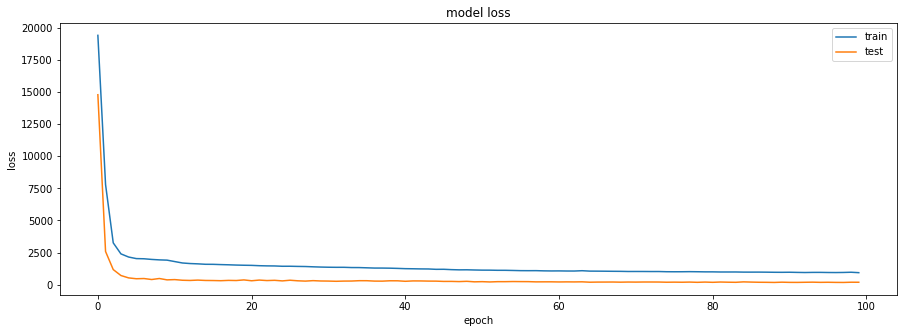

In [24]:
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [25]:
y_pred_nn = model.predict(test_dataset)
y_true = np.reshape(test_y.values, (y_pred_nn.shape[0],1))
mse = mean_squared_error(y_true, y_pred_nn)
rmse = np.sqrt(mse)
print('MSE: {}, RMSE: {}'.format(mse, rmse))

MSE: 190.76564580701276, RMSE: 13.811793721563205


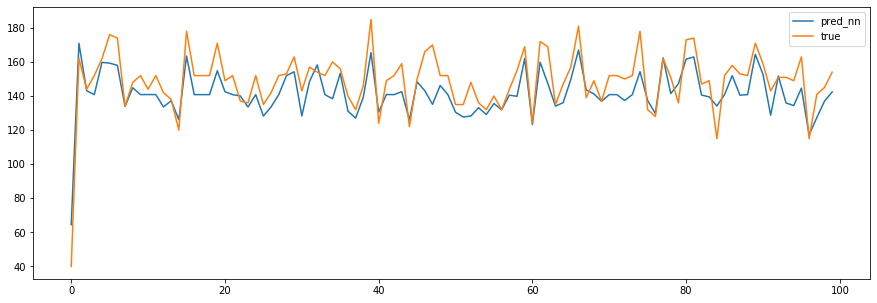

In [26]:
plt.figure(figsize=(15,5))
plt.plot(y_pred_nn[200:300], '-', label='pred_nn')
plt.plot(y_true[200:300], '-', label='true')
plt.legend()
plt.show()

# Model Linear Regression

## Train

In [27]:
model = LinearRegression()
model.fit(train_dataset, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [28]:
y_pred_lr = model.predict(test_dataset)
y_true = np.reshape(test_y.values, (y_pred_lr.shape[0],1))
mse = mean_squared_error(y_true, y_pred_lr)
rmse = np.sqrt(mse)
print('MSE: {}, RMSE: {}'.format(mse, rmse))

MSE: 348.1478485880138, RMSE: 18.658720443482018


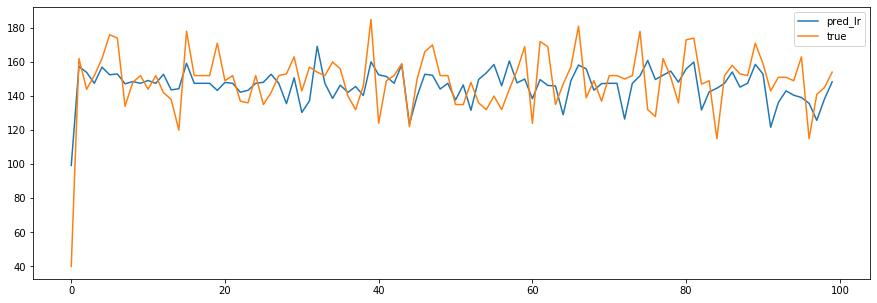

In [29]:
plt.figure(figsize=(15,5))
plt.plot(y_pred_lr[200:300], label='pred_lr')
plt.plot(y_true[200:300], label='true')
plt.legend()
plt.show();

# Model DecisionTreeRegressor

## Train

In [11]:
model = DecisionTreeRegressor(max_depth=22, min_samples_leaf=10)
model.fit(train_dataset, train_y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=22,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [12]:
y_pred_dtr = model.predict(test_dataset)
y_true = np.reshape(test_y.values, (y_pred_dtr.shape[0],1))
mse = mean_squared_error(y_true, y_pred_dtr)
rmse = np.sqrt(mse)
print('MSE: {}, RMSE: {}'.format(mse, rmse))

MSE: 67.31109600689646, RMSE: 8.204333977045087


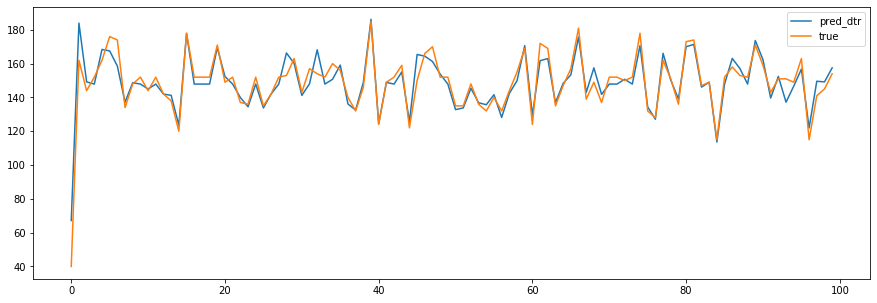

In [13]:
plt.figure(figsize=(15,5))
plt.plot(y_pred_dtr[200:300], label='pred_dtr')
plt.plot(y_true[200:300], label='true')
plt.legend()
plt.show();

In [0]:
param_grid = {'max_depth': np.arange(20, 30),
              'min_samples_leaf': [5, 10, 15]}
gs = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error')
gs.fit(train_dataset, train_y)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=19, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=5,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                         'min_samples_leaf': [5, 10, 15]},
        

In [0]:
gs.best_params_

{'max_depth': 22, 'min_samples_leaf': 10}

In [0]:
gs.best_score_

-10.588165782883923

# Model RandomForestRegressor

## Train

In [14]:
model = RandomForestRegressor(n_estimators=100, max_features=4)
model.fit(train_dataset, train_y)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=4, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [16]:
y_pred_rfr = model.predict(test_dataset)
y_true = np.reshape(test_y.values, (y_pred_rfr.shape[0],1))
mse = mean_squared_error(y_true, y_pred_rfr)
rmse = np.sqrt(mse)
print('MSE: {}, RMSE: {}'.format(mse, rmse))

MSE: 50.48216853707105, RMSE: 7.105080473652008


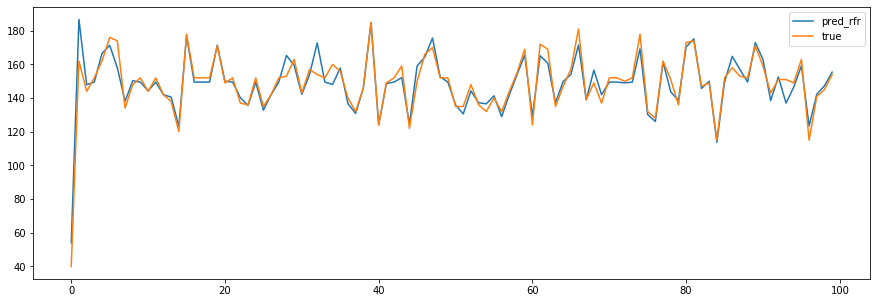

In [17]:
plt.figure(figsize=(15,5))
plt.plot(y_pred_rfr[200:300], label='pred_rfr')
plt.plot(y_true[200:300], label='true')
plt.legend()
plt.show();

In [0]:
score = cross_val_score(model,train_dataset, train_y, scoring='neg_mean_squared_error', cv=10)

In [19]:
np.sqrt(-score).mean()

7.052741963480048

In [20]:
np.sqrt(-score).std()

0.21987563359406972

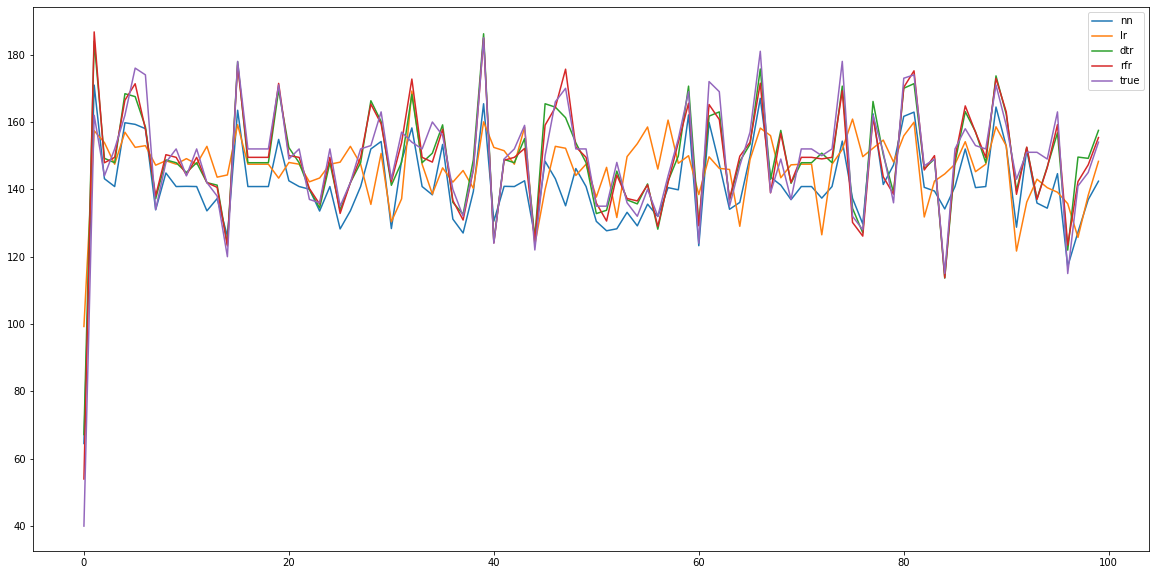

In [30]:
plt.figure(figsize=(20, 10))
plt.plot(y_pred_nn[200:300], label='nn')
plt.plot(y_pred_lr[200:300], label='lr')
plt.plot(y_pred_dtr[200:300], label='dtr')
plt.plot(y_pred_rfr[200:300], label='rfr')
plt.plot(y_true[200:300], label='true')
plt.legend()
plt.show();